In [440]:
from datetime import date
import math
import urllib.request
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

state_url = "https://covidtracking.com/api/states/daily"
state_path = "covidtrack_{}.json".format(date.today())

state_population_url = "https://datausa.io/api/data?drilldowns=State&measures=Population&year=latest"
state_population_path = "usp_{}.json".format(date.today().year)
state_codes_path = "us_state_codes.json" # from https://worldpopulationreview.com/states/state-abbreviations/

metric = "positive"

In [441]:
try:
    state_file = open(state_path)
except IOError:
    urllib.request.urlretrieve(state_url, state_path)
    state_file = open(state_path)
    
states_data = json.load(state_file)

In [442]:
state_codes_data = {h["State"]: h["Code"] for h in json.load(open(state_codes_path))["data"]}

try:
    state_population_file = open(state_population_path)
except IOError:
    urllib.request.urlretrieve(state_population_url, state_population_path)
    state_population_file = open(state_population_path)
   
states_population_data = json.load(state_population_file)
state_populations = {state_codes_data[h["State"]]: h["Population"] for h in states_population_data["data"] if h["State"] in state_codes_data}

In [443]:
states = state_populations.keys()
dates = [h["date"] for h in states_data]
dates.reverse()

def datestamp_to_date(datestamp):
    yr = int(datestamp / 10000)
    datestamp %= 10000
    mo = int(datestamp / 100)
    datestamp %= 100
    d = datestamp
    return date(yr, mo, d)

In [444]:
def metric_val(h, metric="total_per_capita"):
    def positive():
        return h["positive"]
    
    def positive_per_capita():
        return h["positive"] / state_populations[h["state"]]
    
    def total():
        return h["total"]
    
    def total_per_capita():
        return h["total"] / state_populations[h["state"]]

    switcher = {
        "positive": positive,
        "positive_per_capita": positive_per_capita,
        "total": total,
        "total_per_capita": total_per_capita
    }
    
    return switcher[metric]()
    

def state_series(state):
    idx = pd.date_range(dates[0], dates[-1])
    srs = pd.Series({datestamp_to_date(h["date"]): metric_val(h, metric) for h in states_data if h["state"] == state})
    srs.index = pd.DatetimeIndex(srs.index)

    srs.reindex(idx, fill_value=0)
    return srs

In [445]:
df = pd.DataFrame({state: state_series(state) for state in states})

state_cols = df.columns

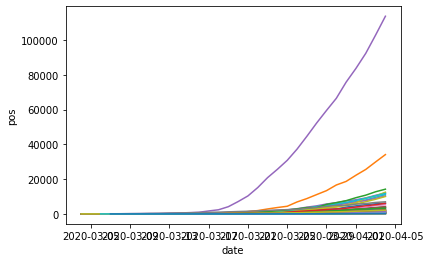

In [446]:
plt.clf()
plt.axes(ylabel='pos', xlabel='date')
plt.yscale("linear")

for state in state_cols:
    plt.plot(df.index, df[state], marker='', label=state)

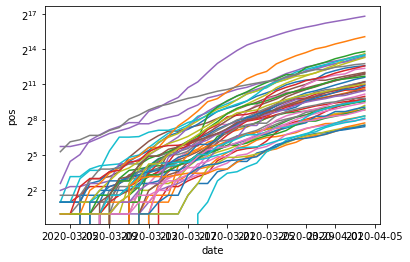

In [447]:
plt.clf()
plt.axes(ylabel='pos', xlabel='date')
plt.yscale("log", basey=2)

for state in state_cols:
    plt.plot(df.index, df[state], marker='', label=state)

In [448]:
xpose = df.tail(1).transpose()
top_state_cols = xpose.nlargest(10, xpose.columns).transpose().columns
df[top_state_cols].tail(5)

,NY,NJ,MI,LA,CA,MA,FL,IL,PA,WA
2020-03-31,75795,18696.0,7615.0,5237.0,7482,6620,6338,5994,4843.0,4896
2020-04-01,83712,22255.0,9334.0,6424.0,8155,7738,6955,6980,5805.0,5634
2020-04-02,92381,25590.0,10791.0,9150.0,9191,8966,8010,7695,7016.0,5984
2020-04-03,102863,29895.0,12744.0,10297.0,10701,10402,9585,8904,8420.0,6585
2020-04-04,113704,34124.0,14225.0,12496.0,12026,11736,11111,10357,10017.0,6966


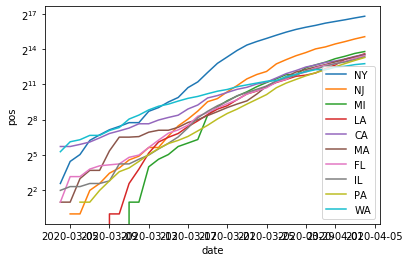

In [449]:
plt.clf()
plt.axes(ylabel='pos', xlabel='date')
plt.yscale("log", basey=2)

for state in top_state_cols:
    plt.plot(df.index, df[state], marker='', label=state)

plt.legend();

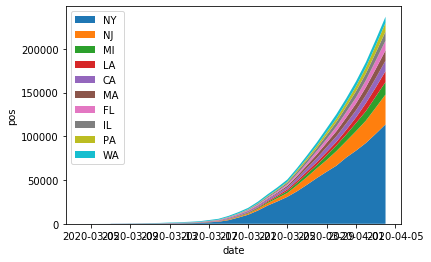

In [450]:
plt.clf()
plt.axes(ylabel='pos', xlabel='date')
plt.yscale("linear")

plt.stackplot(df.index, *[df[state] for state in top_state_cols if state != 'TOT'], labels=top_state_cols);
plt.legend(loc="upper left");

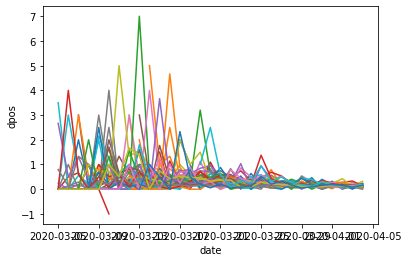

In [451]:
plt.clf()
plt.axes(ylabel='dpos', xlabel='date')
plt.yscale('linear')

plt.plot(df.index, df.pct_change());

In [452]:
dfp = df.pct_change()
xpose = dfp.tail(1).transpose()
top_state_cols = xpose.nlargest(10, xpose.columns).transpose().columns
top_state_cols = [top_state_cols[i] for i in range(1, len(top_state_cols))]
dfp[top_state_cols].tail(5)

,SC,NM,LA,VA,DC,WV,PA,VT,OK
2020-03-31,0.170811,0.185654,0.301118,0.225490,0.234414,0.285714,0.184977,0.144531,0.174636
2020-04-01,0.193906,0.120996,0.226656,0.187200,0.183838,0.179012,0.198637,0.095563,0.272566
2020-04-02,0.201856,0.152381,0.424346,0.149596,0.114334,0.136126,0.208613,0.052960,0.222531
2020-04-03,0.000000,0.110193,0.125355,0.179367,0.159265,0.092166,0.200114,0.150888,0.124005
2020-04-04,0.233591,0.228288,0.213557,0.196322,0.191546,0.189873,0.189667,0.185090,0.173077
